# **MNIST Teacher Student MLP**


En este notebook se creara un red neuronal utilizando la arquitectura de MLP(Multilayer Percepetron).

In [1]:
#Run this if you want to force to use CPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import numpy as np 
from keras import layers, models
from keras.utils import to_categorical
from keras.datasets import mnist
import matplotlib.pyplot as plt



## Tensorflow + Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2, l1

import tensorflow_model_optimization as tfmot

## Pruning
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

## Quantization
from qkeras import *

## Knowledge Distillation
from src.distillationClassKeras import *

## Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle

## Pre-processing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

## Training
from sklearn.model_selection import train_test_split

2025-12-15 11:25:21.232197: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-15 11:25:21.329227: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-15 11:25:21.330044: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-15 11:25:22.290575: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from tensorflow.keras.optimizers import RMSprop

In [4]:
(train_data, train_labels) , (test_data, test_labels) = mnist.load_data()

In [5]:
train_data.shape 

(60000, 28, 28)

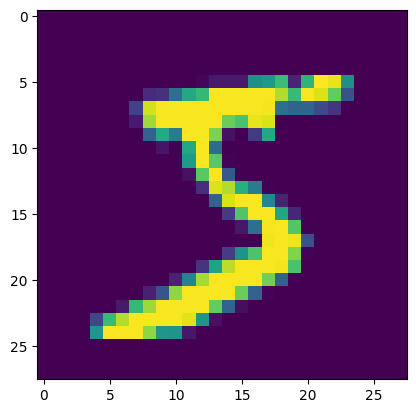

In [6]:
plt.imshow(train_data[0]) #mostrar la primera imagen



## Teacher Training

Los hiperparámetros que definen la arquitectura del modelo *Teacher* son:

* Learning rate
* Número de neuronas
* Número de filtros


In [7]:
# Define the hyperparameters for the teacher model
lr = 0.01
neurons_teacher = [5, 128,32]

### Topologia del modelo Teacher

El input esta dado por la forma de la imagen del mnist (28,28,1) y ofrece una salida de 10, que corresponde a los numeros del 0 al 9

In [8]:
def teacher_topology(bestHP):

    MAX_NEURONS_FC1 = 15     # porque 784×5 = 3920
    MAX_NEURONS = 128        # capas internas sí pueden tener más

    n1 = min(bestHP[0], MAX_NEURONS_FC1)
    n2 = min(bestHP[1], MAX_NEURONS)
    n3 = min(bestHP[2], MAX_NEURONS)

    teacher = keras.models.Sequential(
        [
            keras.Input(shape=(28*28,)),

            Dense(n1, activation='relu', kernel_regularizer=l2(0.001), name='fc1'),
            Dense(n2, activation='relu', kernel_regularizer=l2(0.001), name='fc2'),
            Dense(n3, activation='relu', name='fc3'),    # capa extra pequeña
            Dropout(0.1, name='drop'),

            Dense(10, activation='softmax', name='output'),
        ],
        name="teacher_MLP",
    )

    teacher.summary()
    return teacher



Para la construccion del modelo teacher, se utiliza el optimizador *Adam* que coge de parametro el learning rate, y utilizamos la funcion de perdidas *categorical_crossentropy* y metricas *accuaracy*

In [9]:
 
def build_teacher(neurons_teacher):

    model = teacher_topology(neurons_teacher)
       
    opt = Adam(lr)
    
    model.compile(optimizer=opt, loss=['categorical_crossentropy'], metrics=['accuracy'])
    
    return model

In [10]:
teacher_model = build_teacher(neurons_teacher) 

Model: "teacher_MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 5)                 3925      
                                                                 
 fc2 (Dense)                 (None, 128)               768       
                                                                 
 fc3 (Dense)                 (None, 32)                4128      
                                                                 
 drop (Dropout)              (None, 32)                0         
                                                                 
 output (Dense)              (None, 10)                330       
                                                                 
Total params: 9,151
Trainable params: 9,151
Non-trainable params: 0
_________________________________________________________________


2025-12-15 11:25:27.974681: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-12-15 11:25:27.974727: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: pinpatom
2025-12-15 11:25:27.974747: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: pinpatom
2025-12-15 11:25:27.974932: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 580.82.7
2025-12-15 11:25:27.974972: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 580.82.7
2025-12-15 11:25:27.974987: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 580.82.7


In [11]:
for layer in teacher_model.layers:
    if layer.__class__.__name__ in ['Conv2D', 'Dense']:
        w = layer.get_weights()[0]
        layersize = np.prod(w.shape)
        print("{}: {}".format(layer.name, layersize))  # 0 = weights, 1 = biases
        if layersize > 4096:  # assuming that shape[0] is batch, i.e., 'None'
            print("Layer {} is too large ({}), are you sure you want to train?".format(layer.name, layersize))

fc1: 3920
fc2: 640
fc3: 4096
output: 320


In [12]:
#entrenando el modelo
#cambiando´rimero la forma de los datos
x_train = train_data.reshape((60000,28*28))#bajar a dos dimencionas para facilitar la red neuronal
x_train = x_train.astype('float32')/255 #es mas facil manjear float y /255 es el numero maximo para que me de numero de 0 a 1

x_test = test_data.reshape((10000,28*28))#bajar a dos dimencionas para facilitar la red neuronal
x_test = x_test.astype('float32')/255 #es mas facil manjear float y /255 es el numero maximo para que me de numero de 0 a 1

In [13]:
x_train = train_data.astype("float32") / 255.0
x_test  = test_data.astype("float32") / 255.0

In [14]:
x_train = x_train.reshape((x_train.shape[0], 28*28))
x_test  = x_test.reshape((x_test.shape[0], 28*28))

In [15]:
#hacer una transformacion a los labels

y_train = to_categorical(train_labels, num_classes=10)
y_test  = to_categorical(test_labels, num_classes=10)

In [16]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train,
    test_size=0.1,     # 10% validación
    random_state=42,
    shuffle=True
)

In [17]:
callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=12, verbose=1, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.4, patience=3, verbose=1)
            ] 

history_teacher  = teacher_model.fit(x=x_train, y=y_train,
                  validation_data=(x_test, y_test), 
                  batch_size = 64,
                  epochs=32,
                  callbacks = [callbacks],
                  verbose=1
                  )   

Epoch 1/32


2025-12-15 11:25:29.051696: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169344000 exceeds 10% of free system memory.


835/844 [============================>.] - ETA: 0s - loss: 0.7425 - accuracy: 0.7751

2025-12-15 11:25:33.054196: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


844/844 [==============================] - 4s 4ms/step - loss: 0.7412 - accuracy: 0.7757 - val_loss: 0.5600 - val_accuracy: 0.8454 - lr: 0.0100
Epoch 2/32
844/844 [==============================] - 2s 3ms/step - loss: 0.6220 - accuracy: 0.8288 - val_loss: 0.5472 - val_accuracy: 0.8503 - lr: 0.0100
Epoch 3/32
844/844 [==============================] - 2s 2ms/step - loss: 0.6010 - accuracy: 0.8370 - val_loss: 0.5739 - val_accuracy: 0.8440 - lr: 0.0100
Epoch 4/32
844/844 [==============================] - 2s 2ms/step - loss: 0.5965 - accuracy: 0.8370 - val_loss: 0.5601 - val_accuracy: 0.8420 - lr: 0.0100
Epoch 5/32
844/844 [==============================] - 2s 2ms/step - loss: 0.5818 - accuracy: 0.8423 - val_loss: 0.5193 - val_accuracy: 0.8593 - lr: 0.0100
Epoch 6/32
844/844 [==============================] - 2s 3ms/step - loss: 0.5788 - accuracy: 0.8430 - val_loss: 0.5594 - val_accuracy: 0.8463 - lr: 0.0100
Epoch 7/32
844/844 [==============================] - 2s 2ms/step - loss: 0.5728 

### **Conceptos clave**

En aprendizaje automático, la *accuracy* (precisión) mide qué proporción de predicciones son correctas. Durante el entrenamiento se suelen mostrar dos curvas: la precisión sobre los datos de **entrenamiento**, que indica qué tan bien el modelo aprende de los ejemplos que ya ha visto, y la precisión de **validación**, que muestra qué tan bien generaliza a datos nuevos que no vio durante el entrenamiento. Si ambas curvas suben y se mantienen cercanas, significa que el modelo está aprendiendo correctamente y no está memorizando los datos (sobreajuste). Por otro lado, si la precisión de entrenamiento sube mientras la de validación baja o se estanca, puede indicar problemas de *overfitting*.




dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


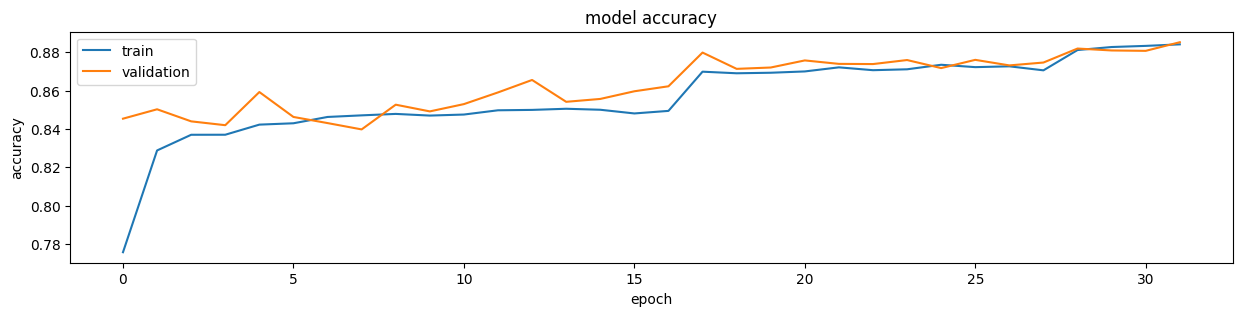

<Figure size 640x480 with 0 Axes>

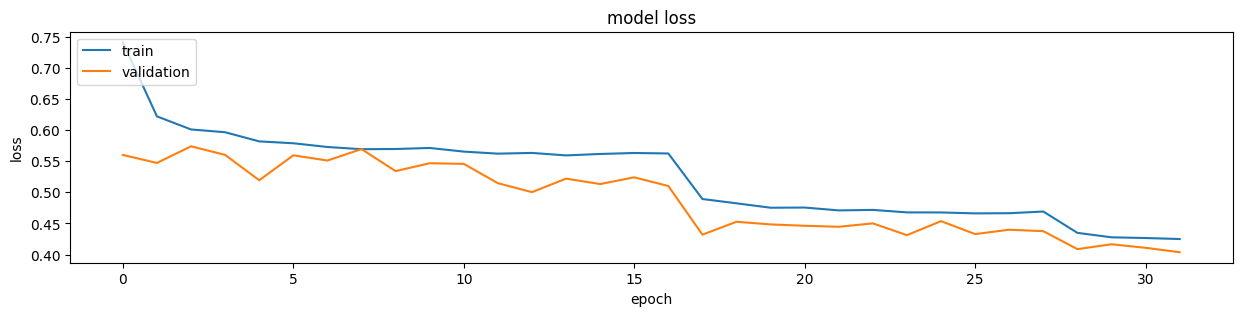

In [18]:
print(history_teacher.history.keys())

## Plot for accuracy
plt.figure(figsize=(15,3))
plt.plot(history_teacher.history['accuracy'])
plt.plot(history_teacher.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.figure()

## Plot for loss
plt.figure(figsize=(15,3))
plt.plot(history_teacher.history['loss'])
plt.plot(history_teacher.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### **Qué es una matriz de confusión**

Una matriz de confusión es una herramienta que permite evaluar el rendimiento de un modelo de clasificación mostrando cuántos ejemplos fueron predichos correctamente y cuántos fueron confundidos con otras clases. Cada fila representa la **etiqueta verdadera**, mientras que cada columna representa la **predicción del modelo**. Los valores en la diagonal indican aciertos: cuantos más valores altos haya allí, mejor es el rendimiento. Los valores fuera de la diagonal indican errores y muestran específicamente qué clases se confunden entre sí, lo que ayuda a identificar patrones de fallo del modelo.



2025-12-15 11:26:28.927209: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


313/313 [==============================] - 1s 2ms/step


<Figure size 700x700 with 0 Axes>

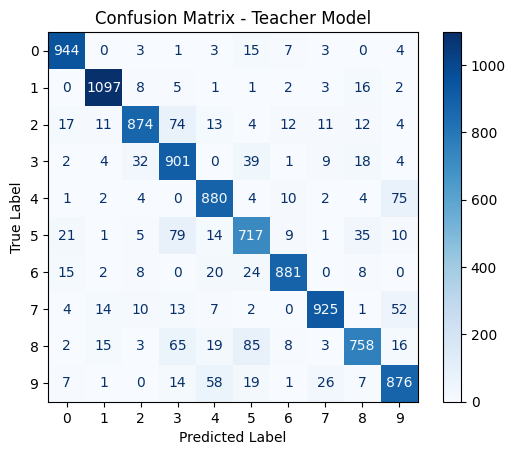

In [19]:
# 1. Predecir probabilidades
y_pred_probs = teacher_model.predict(x_test)   # usa x_test de MNIST

# 2. Convertir a etiquetas predichas
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Convertir y_test one-hot a etiquetas reales
y_true = np.argmax(y_test, axis=1)

# 4. Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# 5. Plot limpio
plt.figure(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Teacher Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [20]:
teacher_model.save('models/MLP/teacherModelMnistMLP.h5')

# **Pruning**


El pruning es una técnica utilizada para reducir el tamaño y la complejidad de un modelo de deep learning mediante la eliminación de pesos o neuronas que se consideran poco relevantes. El objetivo principal es mejorar la eficiencia del modelo reduciendo el consumo de memoria y acelerando la inferencia, todo ello sin afectar de manera significativa la precisión final del modelo.



In [21]:
epochs = 16
lr = 0.001
loss = 'categorical_crossentropy'
op = Adam(lr)
metrics = ['accuracy']
batch = 32
val_split = 0.2

final_sparsity = 0.5

pruning_params = {
                'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                initial_sparsity=0, final_sparsity=final_sparsity, begin_step=0, end_step=1000
                )
            }

callbacks.append(pruning_callbacks.UpdatePruningStep())

In [22]:
modelP = tfmot.sparsity.keras.prune_low_magnitude(teacher_model, **pruning_params)

modelP.compile(optimizer=op, loss=loss, metrics=metrics)

In [23]:
history_P  = modelP.fit(x=x_train, y=y_train,
                  validation_split = val_split,
                  batch_size = 64,
                  epochs=32,
                  callbacks = [callbacks],
                  verbose=1
                  )   

Epoch 1/32


2025-12-15 11:26:31.361290: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 135475200 exceeds 10% of free system memory.


670/675 [============================>.] - ETA: 0s - loss: 0.4206 - accuracy: 0.8865

2025-12-15 11:26:35.946087: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33868800 exceeds 10% of free system memory.


675/675 [==============================] - 5s 3ms/step - loss: 0.4208 - accuracy: 0.8864 - val_loss: 0.3963 - val_accuracy: 0.8904 - lr: 0.0010
Epoch 2/32
675/675 [==============================] - 2s 3ms/step - loss: 0.4297 - accuracy: 0.8821 - val_loss: 0.3979 - val_accuracy: 0.8902 - lr: 0.0010
Epoch 3/32
675/675 [==============================] - 2s 3ms/step - loss: 0.4245 - accuracy: 0.8839 - val_loss: 0.3967 - val_accuracy: 0.8902 - lr: 0.0010
Epoch 4/32
674/675 [============================>.] - ETA: 0s - loss: 0.4233 - accuracy: 0.8842
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
675/675 [==============================] - 2s 3ms/step - loss: 0.4232 - accuracy: 0.8842 - val_loss: 0.3988 - val_accuracy: 0.8883 - lr: 0.0010
Epoch 5/32
675/675 [==============================] - 2s 3ms/step - loss: 0.4089 - accuracy: 0.8889 - val_loss: 0.3948 - val_accuracy: 0.8887 - lr: 4.0000e-04
Epoch 6/32
675/675 [==============================] - 2s 2ms/step - los

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


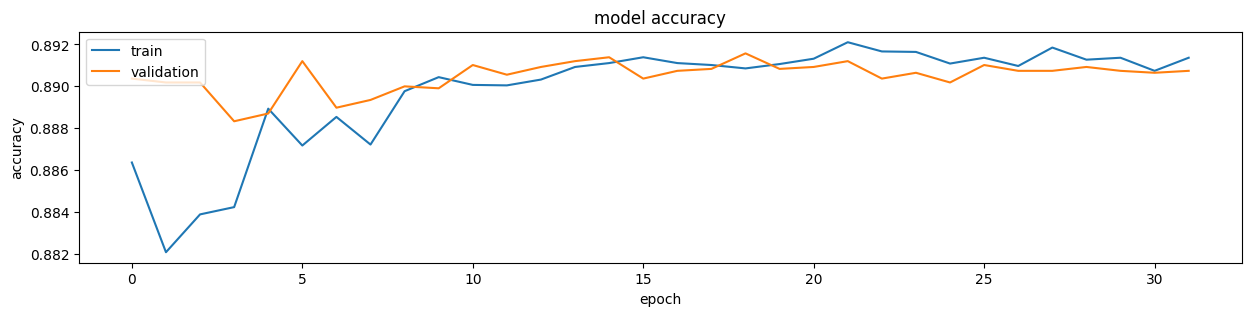

<Figure size 640x480 with 0 Axes>

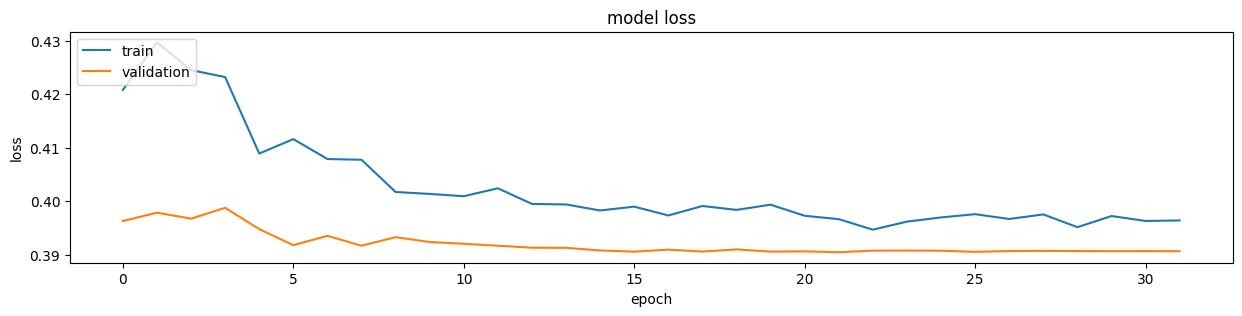

In [24]:
print(history_P.history.keys())

## Plot for accuracy
plt.figure(figsize=(15,3))
plt.plot(history_P.history['accuracy'])
plt.plot(history_P.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.figure()

## Plot for loss
plt.figure(figsize=(15,3))
plt.plot(history_P.history['loss'])
plt.plot(history_P.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

313/313 [==============================] - 0s 1ms/step


<Figure size 700x700 with 0 Axes>

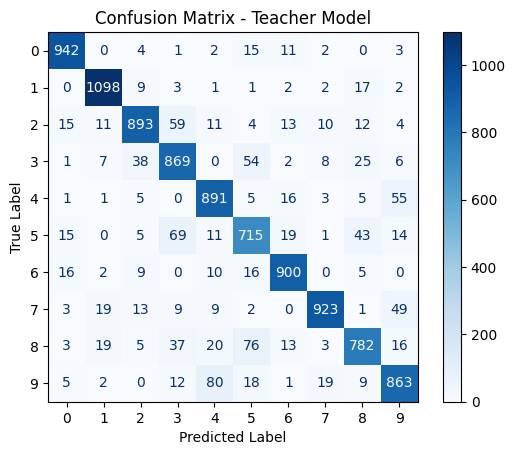

In [25]:
# 1. Predecir probabilidades
y_pred_probs =modelP.predict(x_test)   # usa x_test de MNIST

# 2. Convertir a etiquetas predichas
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Convertir y_test one-hot a etiquetas reales
y_true = np.argmax(y_test, axis=1)

# 4. Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# 5. Plot limpio
plt.figure(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Teacher Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [26]:
modelP.save('models/MLP/teacherModelMnistMLP_pruned.h5')

### **Quantization**


Es una técnica que reduce la precisión numérica de los parámetros de una red neuronal al convertir valores en punto flotante de **32 bits** a representaciones más pequeñas, como **16 bits** o incluso **8 bits**. El objetivo es disminuir el tamaño del modelo, mejorar la velocidad de inferencia y permitir que funcione en dispositivos con recursos limitados.

Para este caso se utilizan **quantization-aware training** (QAT) y **quantization-aware pruning** (QAP):

* **QAT** es una técnica en la que el modelo aprende a adaptarse a la cuantización durante el entrenamiento. En lugar de entrenar el modelo por completo y cuantificarlo al final, la cuantización se introduce desde el proceso de entrenamiento para que el modelo aprenda a trabajar bajo esa restricción numérica.

* **QAP** combina el *pruning* con QAT. La idea es reducir el modelo a través de poda antes de cuantificarlo, logrando una red más eficiente en tamaño y velocidad sin sacrificar la precisión.




In [27]:
# Estrategia de cuantización – 6 bits
kernelQ = "quantized_bits(6,0,alpha=1)"
biasQ   = "quantized_bits(6,0,alpha=1)"
activationQ = "quantized_relu(6)"

modelQAT = Sequential(
    [

        keras.Input(shape=(28*28,)),

        # Capa 1 (equivalente a fc1)
        QDense(neurons_teacher[0], 
               name='fc1',
               kernel_quantizer=kernelQ,
               bias_quantizer=biasQ,
               kernel_initializer='lecun_uniform'),
        QActivation(activation=activationQ, name='relu1'),

        # Capa 2 (equivalente a fc2)
        QDense(neurons_teacher[1],
               name='fc2',
               kernel_quantizer=kernelQ,
               bias_quantizer=biasQ,
               kernel_initializer='lecun_uniform'),
        QActivation(activation=activationQ, name='relu2'),
                # Capa 2 (equivalente a fc2)

        QDense(neurons_teacher[2],
               name='fc3',
               kernel_quantizer=kernelQ,
               bias_quantizer=biasQ,
               kernel_initializer='lecun_uniform'),
        QActivation(activation=activationQ, name='relu3'),

        # Dropout igual que el teacher
        Dropout(0.1, name='drop1'),

        # Capa final softmax (no cuantizamos la activación de salida)
        QDense(10,
               name='output',
               kernel_quantizer=kernelQ,
               bias_quantizer=biasQ,
               kernel_initializer='lecun_uniform'),
        QActivation('softmax', name='softmax'),
    ],
    name="quantized_teacher_MLP",
)


In [28]:
modelQAT.summary()

Model: "quantized_teacher_MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 5)                 3925      
                                                                 
 relu1 (QActivation)         (None, 5)                 0         
                                                                 
 fc2 (QDense)                (None, 128)               768       
                                                                 
 relu2 (QActivation)         (None, 128)               0         
                                                                 
 fc3 (QDense)                (None, 32)                4128      
                                                                 
 relu3 (QActivation)         (None, 32)                0         
                                                                 
 drop1 (Dropout)             (None, 32)      

In [29]:
# Model Training

epochs = 16
lr = 0.001
loss = 'categorical_crossentropy'
op = Adam(lr)
metrics = ['accuracy']
batch = 32
val_split = 0.2


modelQAT.compile(optimizer=op, loss=loss, metrics=metrics)
                
historyQAT = modelQAT.fit(x=x_train, y=y_train,
                validation_split = val_split,
                epochs=epochs,
                batch_size = batch,
                verbose=1
                )

Epoch 1/16
1350/1350 [==============================] - 6s 3ms/step - loss: 0.8600 - accuracy: 0.7459 - val_loss: 0.5565 - val_accuracy: 0.8332
Epoch 2/16
1350/1350 [==============================] - 4s 3ms/step - loss: 0.5397 - accuracy: 0.8434 - val_loss: 0.4716 - val_accuracy: 0.8620
Epoch 3/16
1350/1350 [==============================] - 4s 3ms/step - loss: 0.4894 - accuracy: 0.8606 - val_loss: 0.4729 - val_accuracy: 0.8589
Epoch 4/16
1350/1350 [==============================] - 4s 3ms/step - loss: 0.4604 - accuracy: 0.8680 - val_loss: 0.4553 - val_accuracy: 0.8674
Epoch 5/16
1350/1350 [==============================] - 4s 3ms/step - loss: 0.4459 - accuracy: 0.8722 - val_loss: 0.4470 - val_accuracy: 0.8690
Epoch 6/16
1350/1350 [==============================] - 4s 3ms/step - loss: 0.4388 - accuracy: 0.8740 - val_loss: 0.4542 - val_accuracy: 0.8631
Epoch 7/16
1350/1350 [==============================] - 3s 2ms/step - loss: 0.4313 - accuracy: 0.8768 - val_loss: 0.4635 - val_accuracy:

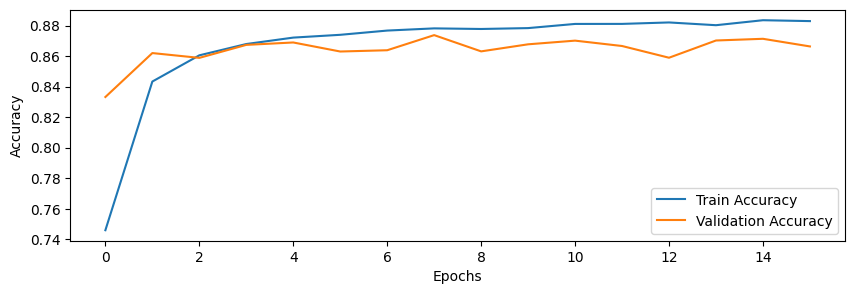

In [30]:
# Plot accuracy over epochs
plt.figure(figsize=(10,3))
plt.plot(historyQAT.history['accuracy'], label='Train Accuracy')
plt.plot(historyQAT.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

313/313 [==============================] - 1s 1ms/step


<Figure size 700x700 with 0 Axes>

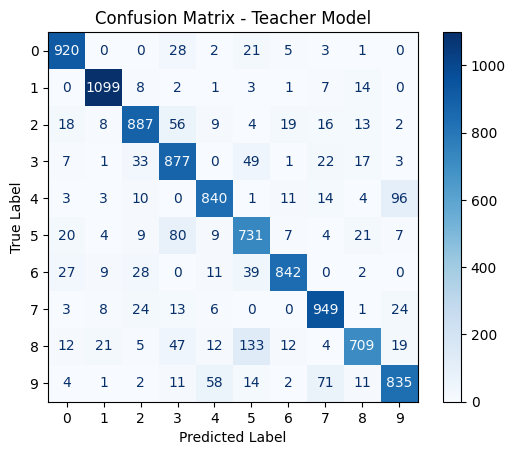

In [31]:
# 1. Predecir probabilidades
y_pred_probs =modelQAT.predict(x_test)   # usa x_test de MNIST

# 2. Convertir a etiquetas predichas
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Convertir y_test one-hot a etiquetas reales
y_true = np.argmax(y_test, axis=1)

# 4. Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# 5. Plot limpio
plt.figure(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Teacher Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [32]:
modelQAT.save('models/MLP/teacherModelQATMnistMLP.h5')

# **Student network** 

Para implementar un modelo de red neuronal en una FPGA, se reduce el tamaño del modelo *Teacher* creando un modelo *Student* mediante **Knowledge Distillation (KD)**. Este método consiste en transferir el conocimiento del modelo *Teacher* al *Student*, permitiendo que el modelo más pequeño mantenga un rendimiento similar al del modelo original.


In [33]:
lr = 0.01
neurons_student = [5,120,32]

In [34]:
def student_topology(neurons_student):
    
    '''
    Model to be trained. Defined with quantization strategies. 
    Input: hyperparams. (bestHP)
    Output: compressed model (studentQ_MLP). 

    '''
    ######## ---------------------------  Model definition - 1D STUDENT -----------------------------------------

    # Number of bits 
    ## 4-bits
    kernelQ_4b = "quantized_bits(4,2,alpha=1)"
    biasQ_4b = "quantized_bits(4,2,alpha=1)"
    activationQ_4b = 'quantized_bits(4, 0)'

    kernelQ = "quantized_bits(6,0,alpha=1)"
    biasQ   = "quantized_bits(6,0,alpha=1)"
    activationQ = "quantized_relu(6)"

    ## 8-bits
    kernelQ_8 = "quantized_bits(8,4,alpha=1)"
    biasQ_8 = "quantized_bits(8,4,alpha=1)"
    activationQ_8 = 'quantized_bits(8)'
    
    ## 16-bits
    kernelQ_16b = "quantized_bits(16,6,alpha=1)"
    biasQ_16b = "quantized_bits(16,6,alpha=1)"
    activationQ_16b = 'quantized_bits(16)'
    
    studentQ_MLP = keras.Sequential(
        [
            Input(shape=(28*28,), name='inputLayer'),

            # Capa 1: equivalente a fc1 del teacher
            QDense(neurons_student[0],
                   kernel_quantizer=kernelQ,
                   bias_quantizer=biasQ,
                   kernel_initializer='lecun_uniform',
                   name='fc1'),
            QActivation(activation=activationQ, name='relu1'),

            # Capa 2: equivalente a fc2 del teacher
            QDense(neurons_student[1],
                   kernel_quantizer=kernelQ,
                   bias_quantizer=biasQ,
                   kernel_initializer='lecun_uniform',
                   name='fc2'),
            QActivation(activation=activationQ, name='relu2'),
              # Capa 2: equivalente a fc3 del teacher
            QDense(neurons_student[2],
                   kernel_quantizer=kernelQ,
                   bias_quantizer=biasQ,
                   kernel_initializer='lecun_uniform',
                   name='fc3'),
            QActivation(activation=activationQ, name='relu3'),

            # Dropout igual al teacher
            Dropout(0.1, name='drop1'),

            # Capa final (10 clases, softmax)
            QDense(10,
                   kernel_quantizer=kernelQ_16b,
                   bias_quantizer=biasQ_16b,
                   kernel_initializer='lecun_uniform',
                   name='output'),
            Activation(activation='softmax', name='outputActivation')
        ],
        name="studentMLP",
    )


    return studentQ_MLP

In [35]:
def build_student(student_neurons):

    '''
    Model to be compressed. Defined with quantization strategies. 
    Input: hyperparams (student_neurons).
    Output: compressed model (studentQ). 

    '''
    
    qmodel = student_topology(student_neurons)

    # Pruning parameters 
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0, final_sparsity=0.5, begin_step=0, end_step=1000
    )
    }
    
    studentQ = prune.prune_low_magnitude(qmodel, **pruning_params)
    
    
    return studentQ

In [36]:
studentQ = build_student(neurons_student)

distilled_student = Distiller(student=studentQ, teacher=teacher_model)

adam = Adam(lr)

train_labels = np.argmax(y_train, axis=1)

distilled_student.compile(
        optimizer=adam,
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
        student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        distillation_loss_fn=keras.losses.KLDivergence(),
        alpha=0.1, 
        temperature=10,
    )

In [37]:
callbacks = [
                tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3, patience=3, verbose=1),
                ]  

callbacks.append(pruning_callbacks.UpdatePruningStep())

history_studentQPKD = distilled_student.fit(x_train, train_labels, 
                               batch_size = 64, 
                               epochs= 32, 
                               validation_split=0.2,
                               callbacks = callbacks
                               )

Epoch 1/32


/home/pinpa/anaconda3/envs/mf_env/lib/python3.11/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


673/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.7125 - student_loss: 0.9247 - distillation_loss: 1.5239e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 7s 4ms/step - sparse_categorical_accuracy: 0.7125 - student_loss: 0.9250 - distillation_loss: 1.5242e-04 - val_sparse_categorical_accuracy: 0.7587 - val_student_loss: 0.7820 - lr: 0.0100
Epoch 2/32
670/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.7769 - student_loss: 0.7669 - distillation_loss: 1.1810e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 2s 3ms/step - sparse_categorical_accuracy: 0.7766 - student_loss: 0.7678 - distillation_loss: 1.1801e-04 - val_sparse_categorical_accuracy: 0.7791 - val_student_loss: 0.7571 - lr: 0.0100
Epoch 3/32
659/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.7822 - student_loss: 0.7516 - distillation_loss: 1.1538e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 2s 3ms/step - sparse_categorical_accuracy: 0.7821 - student_loss: 0.7524 - distillation_loss: 1.1537e-04 - val_sparse_categorical_accuracy: 0.7932 - val_student_loss: 0.8150 - lr: 0.0100
Epoch 4/32
667/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.7878 - student_loss: 0.7374 - distillation_loss: 1.1218e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 2s 3ms/step - sparse_categorical_accuracy: 0.7875 - student_loss: 0.7378 - distillation_loss: 1.1226e-04 - val_sparse_categorical_accuracy: 0.7995 - val_student_loss: 0.7083 - lr: 0.0100
Epoch 5/32
674/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.7889 - student_loss: 0.7273 - distillation_loss: 1.1118e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 2s 3ms/step - sparse_categorical_accuracy: 0.7888 - student_loss: 0.7281 - distillation_loss: 1.1119e-04 - val_sparse_categorical_accuracy: 0.7953 - val_student_loss: 0.8014 - lr: 0.0100
Epoch 6/32
665/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.7915 - student_loss: 0.7181 - distillation_loss: 1.0960e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 2s 4ms/step - sparse_categorical_accuracy: 0.7917 - student_loss: 0.7174 - distillation_loss: 1.0948e-04 - val_sparse_categorical_accuracy: 0.8060 - val_student_loss: 0.7566 - lr: 0.0100
Epoch 7/32
669/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.7963 - student_loss: 0.7120 - distillation_loss: 1.0940e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 3s 4ms/step - sparse_categorical_accuracy: 0.7964 - student_loss: 0.7115 - distillation_loss: 1.0928e-04 - val_sparse_categorical_accuracy: 0.8051 - val_student_loss: 0.8903 - lr: 0.0100
Epoch 8/32
672/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8021 - student_loss: 0.6962 - distillation_loss: 1.0572e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 2s 4ms/step - sparse_categorical_accuracy: 0.8022 - student_loss: 0.6954 - distillation_loss: 1.0569e-04 - val_sparse_categorical_accuracy: 0.8019 - val_student_loss: 0.7282 - lr: 0.0100
Epoch 9/32
673/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8049 - student_loss: 0.6916 - distillation_loss: 1.0589e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 3s 4ms/step - sparse_categorical_accuracy: 0.8049 - student_loss: 0.6920 - distillation_loss: 1.0594e-04 - val_sparse_categorical_accuracy: 0.8116 - val_student_loss: 0.7968 - lr: 0.0100
Epoch 10/32
667/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8035 - student_loss: 0.6958 - distillation_loss: 1.0616e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 2s 4ms/step - sparse_categorical_accuracy: 0.8035 - student_loss: 0.6956 - distillation_loss: 1.0618e-04 - val_sparse_categorical_accuracy: 0.8011 - val_student_loss: 0.8108 - lr: 0.0100
Epoch 11/32
663/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8002 - student_loss: 0.6947 - distillation_loss: 1.0709e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 2s 3ms/step - sparse_categorical_accuracy: 0.8005 - student_loss: 0.6929 - distillation_loss: 1.0703e-04 - val_sparse_categorical_accuracy: 0.7994 - val_student_loss: 0.8435 - lr: 0.0100
Epoch 12/32
663/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8053 - student_loss: 0.6892 - distillation_loss: 1.0525e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 3s 4ms/step - sparse_categorical_accuracy: 0.8053 - student_loss: 0.6884 - distillation_loss: 1.0522e-04 - val_sparse_categorical_accuracy: 0.8149 - val_student_loss: 0.8740 - lr: 0.0100
Epoch 13/32
663/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8061 - student_loss: 0.6923 - distillation_loss: 1.0490e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 3s 4ms/step - sparse_categorical_accuracy: 0.8061 - student_loss: 0.6927 - distillation_loss: 1.0495e-04 - val_sparse_categorical_accuracy: 0.8070 - val_student_loss: 0.7910 - lr: 0.0100
Epoch 14/32
667/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8056 - student_loss: 0.6917 - distillation_loss: 1.0432e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 2s 3ms/step - sparse_categorical_accuracy: 0.8055 - student_loss: 0.6919 - distillation_loss: 1.0423e-04 - val_sparse_categorical_accuracy: 0.8190 - val_student_loss: 0.7116 - lr: 0.0100
Epoch 15/32
674/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8060 - student_loss: 0.6878 - distillation_loss: 1.0399e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 2s 3ms/step - sparse_categorical_accuracy: 0.8060 - student_loss: 0.6883 - distillation_loss: 1.0403e-04 - val_sparse_categorical_accuracy: 0.7984 - val_student_loss: 0.8488 - lr: 0.0100
Epoch 16/32
670/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8053 - student_loss: 0.6887 - distillation_loss: 1.0449e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 2s 3ms/step - sparse_categorical_accuracy: 0.8053 - student_loss: 0.6896 - distillation_loss: 1.0451e-04 - val_sparse_categorical_accuracy: 0.8089 - val_student_loss: 0.7931 - lr: 0.0100
Epoch 17/32
668/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8059 - student_loss: 0.6897 - distillation_loss: 1.0394e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 2s 3ms/step - sparse_categorical_accuracy: 0.8061 - student_loss: 0.6891 - distillation_loss: 1.0382e-04 - val_sparse_categorical_accuracy: 0.8101 - val_student_loss: 0.8530 - lr: 0.0100
Epoch 18/32
658/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8037 - student_loss: 0.6880 - distillation_loss: 1.0509e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 2s 3ms/step - sparse_categorical_accuracy: 0.8037 - student_loss: 0.6874 - distillation_loss: 1.0511e-04 - val_sparse_categorical_accuracy: 0.8031 - val_student_loss: 0.8411 - lr: 0.0100
Epoch 19/32
657/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8080 - student_loss: 0.6873 - distillation_loss: 1.0406e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 2s 3ms/step - sparse_categorical_accuracy: 0.8077 - student_loss: 0.6886 - distillation_loss: 1.0408e-04 - val_sparse_categorical_accuracy: 0.8091 - val_student_loss: 0.6920 - lr: 0.0100
Epoch 20/32
663/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8054 - student_loss: 0.6916 - distillation_loss: 1.0385e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 2s 3ms/step - sparse_categorical_accuracy: 0.8058 - student_loss: 0.6901 - distillation_loss: 1.0377e-04 - val_sparse_categorical_accuracy: 0.8165 - val_student_loss: 0.7769 - lr: 0.0100
Epoch 21/32
663/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8096 - student_loss: 0.6764 - distillation_loss: 1.0160e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 2s 3ms/step - sparse_categorical_accuracy: 0.8093 - student_loss: 0.6771 - distillation_loss: 1.0150e-04 - val_sparse_categorical_accuracy: 0.8118 - val_student_loss: 0.6752 - lr: 0.0100
Epoch 22/32
675/675 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.8087 - student_loss: 0.6762 - distillation_loss: 1.0148e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 2s 3ms/step - sparse_categorical_accuracy: 0.8087 - student_loss: 0.6765 - distillation_loss: 1.0150e-04 - val_sparse_categorical_accuracy: 0.8124 - val_student_loss: 0.7912 - lr: 0.0100
Epoch 23/32
668/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8066 - student_loss: 0.6798 - distillation_loss: 1.0276e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 2s 3ms/step - sparse_categorical_accuracy: 0.8065 - student_loss: 0.6796 - distillation_loss: 1.0277e-04 - val_sparse_categorical_accuracy: 0.8112 - val_student_loss: 0.8349 - lr: 0.0100
Epoch 24/32
671/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8089 - student_loss: 0.6811 - distillation_loss: 1.0114e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 2s 3ms/step - sparse_categorical_accuracy: 0.8090 - student_loss: 0.6812 - distillation_loss: 1.0120e-04 - val_sparse_categorical_accuracy: 0.8025 - val_student_loss: 0.8436 - lr: 0.0100
Epoch 25/32
662/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8093 - student_loss: 0.6839 - distillation_loss: 1.0227e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 2s 3ms/step - sparse_categorical_accuracy: 0.8089 - student_loss: 0.6842 - distillation_loss: 1.0241e-04 - val_sparse_categorical_accuracy: 0.8123 - val_student_loss: 0.8444 - lr: 0.0100
Epoch 26/32
658/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8111 - student_loss: 0.6717 - distillation_loss: 1.0111e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 2s 3ms/step - sparse_categorical_accuracy: 0.8109 - student_loss: 0.6716 - distillation_loss: 1.0111e-04 - val_sparse_categorical_accuracy: 0.8114 - val_student_loss: 0.7268 - lr: 0.0100
Epoch 27/32
672/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8059 - student_loss: 0.6748 - distillation_loss: 1.0219e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 2s 3ms/step - sparse_categorical_accuracy: 0.8059 - student_loss: 0.6747 - distillation_loss: 1.0222e-04 - val_sparse_categorical_accuracy: 0.8072 - val_student_loss: 0.7208 - lr: 0.0100
Epoch 28/32
670/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8039 - student_loss: 0.6759 - distillation_loss: 1.0164e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 2s 3ms/step - sparse_categorical_accuracy: 0.8042 - student_loss: 0.6749 - distillation_loss: 1.0151e-04 - val_sparse_categorical_accuracy: 0.8107 - val_student_loss: 0.8599 - lr: 0.0100
Epoch 29/32
674/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8098 - student_loss: 0.6741 - distillation_loss: 1.0184e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 2s 3ms/step - sparse_categorical_accuracy: 0.8097 - student_loss: 0.6741 - distillation_loss: 1.0191e-04 - val_sparse_categorical_accuracy: 0.8001 - val_student_loss: 0.7820 - lr: 0.0100
Epoch 30/32
671/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8057 - student_loss: 0.6824 - distillation_loss: 1.0273e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 2s 3ms/step - sparse_categorical_accuracy: 0.8056 - student_loss: 0.6820 - distillation_loss: 1.0272e-04 - val_sparse_categorical_accuracy: 0.8067 - val_student_loss: 0.7231 - lr: 0.0100
Epoch 31/32
672/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8104 - student_loss: 0.6681 - distillation_loss: 1.0085e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 2s 3ms/step - sparse_categorical_accuracy: 0.8103 - student_loss: 0.6682 - distillation_loss: 1.0087e-04 - val_sparse_categorical_accuracy: 0.8130 - val_student_loss: 0.7455 - lr: 0.0100
Epoch 32/32
667/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8064 - student_loss: 0.6832 - distillation_loss: 1.0398e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 2s 3ms/step - sparse_categorical_accuracy: 0.8066 - student_loss: 0.6829 - distillation_loss: 1.0396e-04 - val_sparse_categorical_accuracy: 0.7967 - val_student_loss: 0.8195 - lr: 0.0100


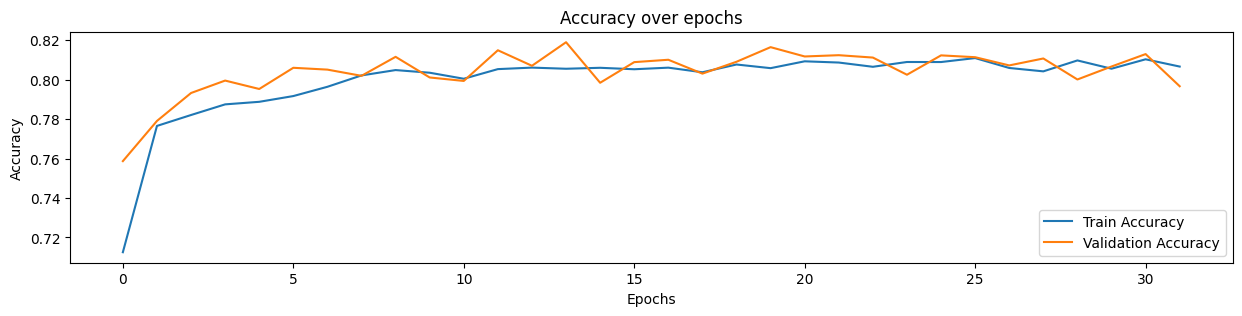

In [38]:
# Plot accuracy over epochs
plt.figure(figsize=(15,3))
plt.plot(history_studentQPKD.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history_studentQPKD.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

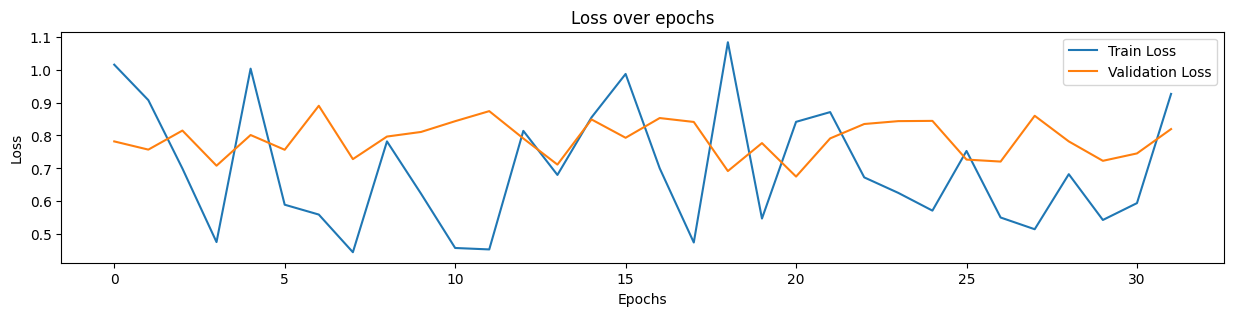

In [39]:
# Plot loss over epochs
plt.figure(figsize=(15,3))
plt.plot(history_studentQPKD.history['student_loss'], label='Train Loss')
plt.plot(history_studentQPKD.history['val_student_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

313/313 [==============================] - 1s 1ms/step


<Figure size 700x700 with 0 Axes>

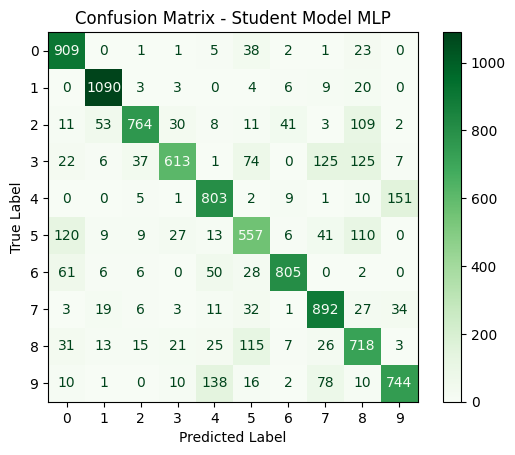

In [40]:
# 1. Predecir probabilidades
y_pred_probs =distilled_student.student.predict(x_test)   # usa x_test de MNIST

# 2. Convertir a etiquetas predichas
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Convertir y_test one-hot a etiquetas reales
y_true = np.argmax(y_test, axis=1)

# 4. Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# 5. Plot limpio
plt.figure(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Greens", values_format='d')
plt.title("Confusion Matrix - Student Model MLP")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [41]:
student_only = distilled_student.student

test_labels = np.argmax(y_test, axis=1)

student_only.predict(x_test)


313/313 [==============================] - 0s 1ms/step


array([[3.5495027e-06, 7.4684988e-03, 6.3854380e-04, ..., 9.2804641e-01,
        6.6326950e-03, 3.4893114e-02],
       [7.5551501e-04, 7.7602966e-03, 9.3655002e-01, ..., 2.8344530e-03,
        2.3727514e-02, 3.5152942e-04],
       [1.8784452e-06, 9.8704612e-01, 3.4535851e-03, ..., 1.5556555e-03,
        6.6097924e-03, 3.6592210e-05],
       ...,
       [5.2403825e-06, 6.9931534e-04, 3.5429845e-04, ..., 3.4876067e-02,
        3.0068818e-03, 8.9565820e-01],
       [2.3509350e-02, 2.7436698e-03, 2.3300072e-02, ..., 2.4671443e-02,
        1.4403419e-01, 1.7319901e-02],
       [1.3104422e-03, 8.4562047e-04, 1.6683187e-02, ..., 5.3608388e-04,
        2.0497581e-03, 3.5646642e-04]], dtype=float32)

1/1 [==============================] - 0s 16ms/step
Label real: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Predicción: 5
Probabilidades: [[0.05873323 0.00310592 0.02027228 0.2607297  0.00571004 0.442921
  0.00330099 0.11814938 0.0390675  0.04800987]]


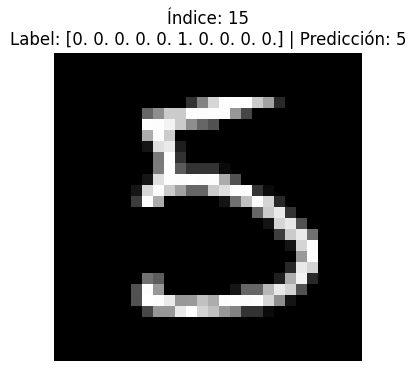

In [42]:
import numpy as np
import matplotlib.pyplot as plt

indexPrediction = 15

# Sacas el vector aplanado (784,)
x_input = x_test[indexPrediction]
y_label = y_test[indexPrediction]

# Para el modelo: necesita (1, 784)
inputPred = np.expand_dims(x_input, axis=0)

# Predicción
y_pred = distilled_student.student.predict(inputPred)
pred_class = np.argmax(y_pred)

print("Label real:", y_label)
print("Predicción:", pred_class)
print("Probabilidades:", y_pred)

# --- Graficar la imagen reconstruida ---
img_2d = x_input.reshape(28, 28)   # <---- ¡IMPORTANTE!

plt.figure(figsize=(4,4))
plt.imshow(img_2d, cmap='gray')
plt.title(f"Índice: {indexPrediction}\nLabel: {y_label} | Predicción: {pred_class}")
plt.axis('off')
plt.show()


In [43]:
model = strip_pruning(distilled_student.student)
model.summary()
model.save('models/MLP/studentModelMnistMLP.h5')

Model: "studentMLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 5)                 3925      
                                                                 
 relu1 (QActivation)         (None, 5)                 0         
                                                                 
 fc2 (QDense)                (None, 120)               720       
                                                                 
 relu2 (QActivation)         (None, 120)               0         
                                                                 
 fc3 (QDense)                (None, 32)                3872      
                                                                 
 relu3 (QActivation)         (None, 32)                0         
                                                                 
 drop1 (Dropout)             (None, 32)                0

In [44]:
for layer in model.layers:
    if layer.__class__.__name__ in ['QConv2D', 'QDense']:
        w = layer.get_weights()[0]
        layersize = np.prod(w.shape)
        print("{}: {}".format(layer.name, layersize))  # 0 = weights, 1 = biases
        if layersize > 4096:  # assuming that shape[0] is batch, i.e., 'None'
            print("Layer {} is too large ({}), are you sure you want to train?".format(layer.name, layersize))

fc1: 3920
fc2: 600
fc3: 3840
output: 320
